In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import itertools 

class ForestFireSimulation:
    empty, tree, fire, char = [0, 1, 2, 3]  # Setup state values

    def __init__(self, size=50, dim=2):
        self.size = size
        self.dim = dim
        self.state = np.zeros(list(itertools.repeat(size, dim)))

    def initialize(self, tree_density=0.4):

        self.state.fill(self.empty)

        # Place random trees with the requested density
        random_indexes = np.random.choice(
            range(self.size ** self.dim),
            size=int(round(tree_density * self.size ** self.dim)),
            replace=False)
        self.state.flat[random_indexes] = self.tree

        # Ignite one random tree
        if len(random_indexes) > 0:
            self.state.flat[random_indexes[0]] = self.fire

        self.time_step = 0
        self.changed = True  # Track whether the state changed between the
                             # previous time step and the current one

    def draw(self):
        plt.cla()
        fig = plt.pcolor(self.state, vmin = 0, vmax = 3, cmap = mpl.colors.ListedColormap(
            ['peru', 'green','red', 'black']))
        plt.axis('image')
        plt.title('t = ' + str(self.time_step))
        return fig.get_figure()

    def update(self):
        self.time_step += 1

        next_state = np.zeros(self.state.shape)
        # Empty cells stay empty
        next_state[np.where(self.state == self.empty)] = self.empty
        # Charred cells stay charred
        next_state[np.where(self.state == self.char)] = self.char
        # Burning cells become charred
        next_state[np.where(self.state == self.fire)] = self.char

        # Check which trees should be ignited (all those with fire neighbors)
        ys, xs = np.where(self.state == self.tree)
        fire_neighbor = np.zeros(len(xs), dtype=bool)


        for dx in [-1, 1]:
        	fire_neighbor = fire_neighbor | (
                    self.state[(ys) % self.size, (xs + dx) % self.size] == self.fire)
        for dy in [-1, 1]:
                fire_neighbor = fire_neighbor | (
                    self.state[(ys + dy) % self.size, (xs) % self.size] == self.fire)
        # Trees with burning neighbors start burning
        next_state[(ys[fire_neighbor], xs[fire_neighbor])] = self.fire
        # Trees without burning neighbors stay the same
        next_state[(ys[~fire_neighbor], xs[~fire_neighbor])] = self.tree

        self.changed = (next_state != self.state).any()
        self.state = next_state

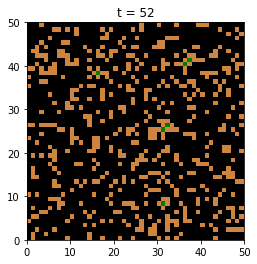

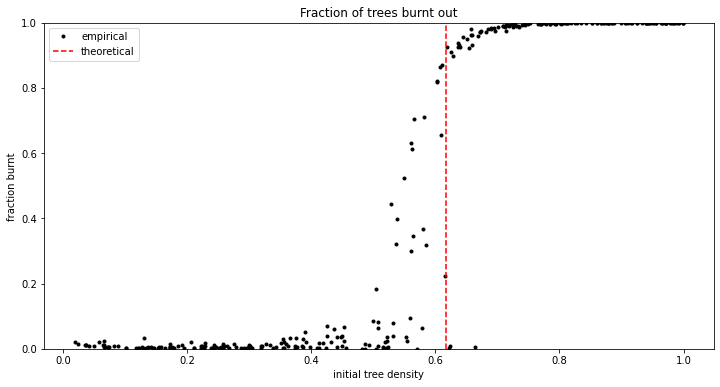

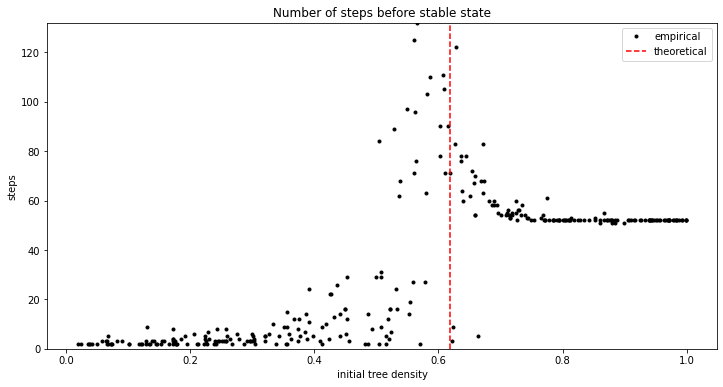

In [ ]:
sim = ForestFireSimulation()

# The initial tree density at which all trees will burn out according
# to the renormalization group analysis, shown on the plots below.
theoretical_critical = 0.618
n_experiment = 300

# Run experiments and record data for the result plots
plot_data = {
    'prob': [],   # The initial tree density
    'burnt': [],  # The proportion of trees that burned out
    'time': []}   # The number of steps for the simulation to stabilize
for experiment in range(n_experiment):
    tree_density = np.random.uniform(0.01, 1)
    sim.initialize(tree_density)
    try:
      os.mkdir("e_{e:0{ew}d}".format(e=experiment,ew=(str(0)+str(len(str(n_experiment)))))) 
    except:
      pass
    while sim.changed:  # Run until the state stops changing
        sim.update()
        img = sim.draw()
        img.savefig("e_{e:0{ew}d}/t_{t:0{tw}d}.png".format(e=experiment, t = sim.time_step, ew=(str(0)+str(len(str(n_experiment)))), tw=3))

    plot_data['prob'].append(tree_density)
    plot_data['time'].append(sim.time_step)
    plot_data['burnt'].append((sim.state == sim.char).mean() / tree_density)

# Plot experimental results
plt.figure(figsize=(12, 6))
plt.title('Fraction of trees burnt out')
plt.xlabel('initial tree density')
plt.ylabel('fraction burnt')
plt.plot(plot_data['prob'], plot_data['burnt'], 'k.', label='empirical')
plt.axvline(theoretical_critical, color='red', linestyle='--', label='theoretical')
plt.ylim(0, 1)
plt.legend()

plt.figure(figsize=(12, 6))
plt.title('Number of steps before stable state')
plt.xlabel('initial tree density')
plt.ylabel('steps')
plt.plot(plot_data['prob'], plot_data['time'], 'k.', label='empirical')
plt.axvline(theoretical_critical, color='red', linestyle='--', label='theoretical')
plt.ylim(0, max(plot_data['time']))
plt.legend()

plt.show()

In [ ]:
import imageio
import glob

for exprmnt_folder in glob.glob('e_*'):
    images = []
    file_paths = sorted(glob.glob(f"{exprmnt_folder}/*.png"))
    for file_path in file_paths:
        images.append(imageio.imread(file_path))
    try:
        os.mkdir('GIFs')
    except:
        pass
    imageio.mimwrite('GIFs/' + str(exprmnt_folder) + '.gif', images, fps=5)